In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import urllib.parse
import os

In [ ]:
# Parameters
lat = 0.0  # Default latitude
lng = 0.0  # Default longitude

In [ ]:
ZARR_FILE = "https://apps.copernicus-climate.eu/c3s-apps/era-explorer-server/zarr"

# Define climatology periods
clim_year_start = 1991
clim_year_end = 2020

clim_year_stripes_start = 1961
clim_year_stripes_end = 2010

norm_stripes_start = 1940
norm_stripes_end = 1999

# Create slices for the climatology periods
climatology_period = slice('{:d}-01-01'.format(clim_year_start), '{:d}-12-31'.format(clim_year_end))
climatology_period_stripes = slice('{:d}-01-01'.format(clim_year_stripes_start), '{:d}-12-31'.format(clim_year_stripes_end))
normalisation_period_stripes = slice('{:d}-01-01'.format(norm_stripes_start), '{:d}-12-31'.format(norm_stripes_end))  # Not the same as the clim period

def temperatureAnnualTimeseries(x, y):
    """
    Handles the temperature annual timeseries request.
    This function processes a request to compute annual temperature statistics 
    for a given geographical location specified by latitude (x) and longitude (y). 
    The function supports both online and offline versions of data retrieval.
    The function performs the following steps:
    1. Retrieves query parameters from the request URL.
    2. Loads the temperature data from a specified source.
    3. Selects the temperature data for the specified location.
    4. Computes annual temperature statistics and anomalies.
    5. Converts the results to JSON format and returns them in the response.
    Returns:
        Response: A JSON response containing the annual temperature statistics 
                  including time, absolute values, anomalies, anomaly scaling, 
                  climatology period, and the specified coordinates.
    """
    print("Processing temperature annual timeseries for coordinates ({}, {})".format(x, y))

    data = xr.open_zarr(ZARR_FILE)
    data_t2m = data.t2m
    data_t2m_pt = data_t2m.sel(latitude=y, longitude=x, method='nearest')  # Returns data array time series

    # Remove incomplete year
    current_year = datetime.now().year
    timestamp_string = '{:d}-12-31 00:00:00'.format(current_year - 1)
    cutoff_date = pd.Timestamp(timestamp_string)
    data_t2m_pt_trun = data_t2m_pt.sel(time=slice(None, cutoff_date))

    # Resample the data to annual means
    data_t2m_pt_agg = data_t2m_pt_trun.resample(time="YE").mean()
    years = data_t2m_pt_agg.time.to_index().year
    abs_values = (data_t2m_pt_agg - 273.15).values  # Convert from Kelvin to Celsius

    return (years, abs_values)

Extracted Parameters: {}


In [ ]:
x1 = lng
y1 = lat
x2, y2 = None, None

gotA = ((x1 is not None) and (y1 is not None))
gotB = ((x2 is not None) and (y2 is not None))

if gotA: years1, ts1 = temperatureAnnualTimeseries(x1, y1)
if gotB: years2, ts2 = temperatureAnnualTimeseries(x2, y2)

Processing temperature annual timeseries for coordinates (10, 50)
Processing temperature annual timeseries for coordinates (-100, 30)


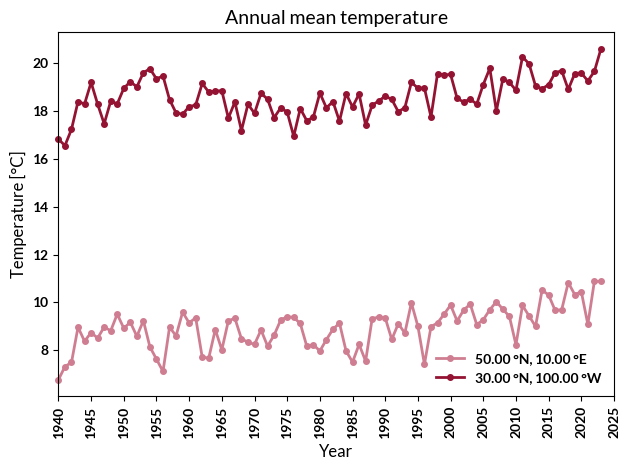

In [ ]:
# Set Lato font globally in rcParams
rcParams.update({
    # 'font.family': 'Lato',
    'font.size': 10,
    'font.weight': '700'  # Bold
})

lw = 2
marker = 'o'
markersize = 4

if gotA:
    y1suff = 'N' if y1 > 0 else 'S'
    x1suff = 'E' if x1 > 0 else 'W'
if gotB:
    y2suff = 'N' if y2 > 0 else 'S'
    x2suff = 'E' if x2 > 0 else 'W'

# Plot the data
if gotA: plt.plot(years1, ts1, marker=marker, markersize=markersize, label=f'{abs(y1):.2f} °{y1suff:s}, {abs(x1):.2f} °{x1suff:s}', color='#CF7E92', lw=lw, clip_on=False)
if gotB: plt.plot(years2, ts2, marker=marker, markersize=markersize, label=f'{abs(y2):.2f} °{y2suff:s}, {abs(x2):.2f} °{x2suff:s}', color='#941333', lw=lw, clip_on=False)

# Add legend
plt.legend(framealpha=0)

# Set x-ticks to appear every 10 years and rotate them
plt.xticks(np.arange(1940, 2026, 5), rotation=90)
plt.xlim(1940, 2025)

# Customize x and y axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)

# Add title with custom font
plt.title('Annual mean temperature', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()